<a href="https://colab.research.google.com/github/pqrt12/BigData/blob/master/Challenge_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Java, Spark, Findspark, postgres, etc.

In [0]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ChallengeAnalysis").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

## Extract



In [0]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
aws_s3_base_url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/"
# filename = "sample_us.tsv"
filename = "amazon_reviews_us_Wireless_v1_00.tsv.gz"
spark.sparkContext.addFile(aws_s3_base_url + filename)
raw_data_df = spark.read.csv(SparkFiles.get(filename), sep="\t", header=True, inferSchema=True)

In [0]:
# count the total records
raw_data_df.count()

9002021

In [0]:
# Show DataFrame
raw_data_df.show(3)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...|2015-08-31 00:00:00|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516894650|Selfie Stick Fibl...| 

## Transform
### filtering

In [0]:
# transform, filtering:
#   dropna, keep essentail columns only
clean_data_df = raw_data_df.dropna().select(['star_rating', 'helpful_votes', 'total_votes', 'vine'])
clean_data_df.show(3)

+-----------+-------------+-----------+----+
|star_rating|helpful_votes|total_votes|vine|
+-----------+-------------+-----------+----+
|          2|            1|          3|   N|
|          4|            0|          0|   N|
|          5|            0|          0|   N|
+-----------+-------------+-----------+----+
only showing top 3 rows



In [0]:
# keep influential opinions only
select_df = clean_data_df.filter((clean_data_df['total_votes'] > 10) & (clean_data_df['helpful_votes'] > 3))
# select_df = clean_data_df

In [0]:
select_df.count()

143633

### transform to numpy, scipy, pandas
  vine_arr, non_vine_arr and pdf

*   vine_arr: np array of "star_rating" by vine.
*   non_vine_arr: np array of "star_rating" by non_vine.
*   pdf: pandas df of "star_rating", "vine" and count


In [0]:
# import the math module  
import numpy as np
from scipy import stats
import pandas as pd

In [0]:
# get vine's numpy arr of "star_rating" 
a = select_df.filter(select_df.vine == 'Y')       \
            .select('star_rating')                \
            .rdd.flatMap(lambda x: x)             \
            .collect()
vine_arr = np.array(a).astype(float)

In [0]:
# get non_vine's numpy arr of "star_rating" 
a = select_df.filter(select_df.vine == 'N')       \
            .select('star_rating')                \
            .rdd.flatMap(lambda x: x)             \
            .collect()
non_vine_arr = np.array(a).astype(float)

In [0]:
select_df = select_df.groupBy('star_rating', 'vine').count()
select_df.show()

+-----------+----+-----+
|star_rating|vine|count|
+-----------+----+-----+
|          5|   N|62440|
|          2|   N|10437|
|          3|   N|12451|
|          1|   Y|   54|
|          2|   Y|   69|
|          4|   N|21593|
|          5|   Y|  375|
|          3|   Y|  196|
|          1|   N|35665|
|          4|   Y|  353|
+-----------+----+-----+



In [0]:
# to pandas dataframe
pdf = select_df.toPandas()

## Analysis

### pandas df plot

In [0]:
pdf = pdf.astype({"star_rating": int})
pdf.head()

,star_rating,vine,count
0,5,N,62440
1,2,N,10437
2,3,N,12451
3,1,Y,54
4,2,Y,69


In [0]:
# vine normalize.
vine = pdf.loc[pdf['vine'] == 'Y']
t = vine.copy(deep=True)
vine['count'] = t['count'] / t['count'].sum()
vine

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,star_rating,vine,count
3,1,Y,0.051576
4,2,Y,0.065903
6,5,Y,0.358166
7,3,Y,0.187202
9,4,Y,0.337154


In [0]:
# non_vine normalize.
non_vine = pdf.loc[pdf['vine'] == 'N']
t = non_vine.copy(deep=True)
non_vine['count'] = t['count'] / t['count'].sum()
non_vine

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,star_rating,vine,count
0,5,N,0.437911
1,2,N,0.073198
2,3,N,0.087323
5,4,N,0.151438
8,1,N,0.250130


In [0]:
# final pandas dataframe
data = {'star_rating':[1, 2, 3, 4, 5]}
final_pdf = pd.DataFrame(data)
final_pdf = pd.merge(final_pdf, vine, on='star_rating', how='left')  #, sort=True)
final_pdf = pd.merge(final_pdf, non_vine, on='star_rating', how='left')  #, sort=True)
final_pdf = final_pdf.fillna(0)
final_pdf = final_pdf.rename(columns={'count_x': 'vine_count', 'count_y': 'non_vine_count'})
final_pdf[['star_rating', 'vine_count', 'non_vine_count']]

,star_rating,vine_count,non_vine_count
0,1,0.051576,0.250130
1,2,0.065903,0.073198
2,3,0.187202,0.087323
3,4,0.337154,0.151438
4,5,0.358166,0.437911


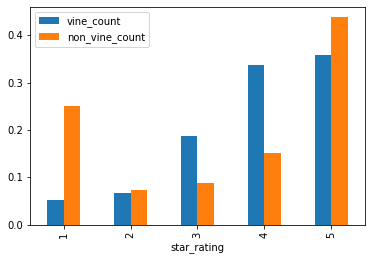

In [0]:
# vine / non_vine normalized "star_rating" distribution
final_pdf.plot(x="star_rating", y=["vine_count", "non_vine_count"], kind="bar")

### statistics

In [0]:
vine_arr = vine_arr.astype(float)

In [0]:
# vine's "star_rating" statistics
stats.describe(vine_arr)

DescribeResult(nobs=1047, minmax=(1.0, 5.0), mean=3.884431709646609, variance=1.2610097866799617, skewness=-0.9267782697431367, kurtosis=0.19481679188842582)

In [0]:
# quick check on distribution.
stats.normaltest(vine_arr)

NormaltestResult(statistic=114.09473154224875, pvalue=1.6774278084337289e-25)

In [0]:
non_vine_arr = non_vine_arr.astype(float)

In [0]:
# non-vine's "star_rating" statistics
stats.describe(non_vine_arr)

DescribeResult(nobs=142586, minmax=(1.0, 5.0), mean=3.4538033186988906, variance=2.770881947331554, skewness=-0.4954615396356368, kurtosis=-1.448054688850543)

In [0]:
# quick check on distribution.
stats.normaltest(non_vine_arr)

NormaltestResult(statistic=1020225.5090764561, pvalue=0.0)

test on the mean "star_rating" from the vine and non-vine groups  
*   null hypothesis: the mean values are statistically same
*   alternative hypothesis: the mean values are not statistically same.

In [0]:
# standard independent 2 sample test
stats.ttest_ind(vine_arr, non_vine_arr)

Ttest_indResult(statistic=8.356833269777933, pvalue=6.49889943959176e-17)

In [0]:
# Welch’s t-test
stats.ttest_ind(vine_arr, non_vine_arr, equal_var=False)

Ttest_indResult(statistic=12.309518431531407, pvalue=1.1139719931541857e-32)